# Post Processing

This notebook run some post processing on result point cloud. 
1. Convert point cloud to DEM with `point2dem` command from ASP.
2. Coregister with reference DEMs.
3. Compute difference between coregistered DEMs and references DEMs.
4. Compute some statistics of this difference.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import history
from glob import glob

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# For testing only

Temporay commands for testing:
- create a symlink to the files needed/working for this notebook
- create downsampled version of the reference DEMs

In [3]:
# !ln -fs /mnt/summer/USERS/DEHECQA/history/output/extracted/**/*dense_pointcloud.laz /mnt/summer/USERS/DEHECQA/history/output/test_data/pointclouds
# !rm /mnt/summer/USERS/DEHECQA/history/output/test_data/HIATUS*laz # wrong code
#!ls -1 /mnt/summer/USERS/DEHECQA/history/output/test_data/pointclouds/*laz

In [ ]:
#!gdal_translate /mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_zoom.tif /home/godinlu/github/history/dev/testset/ref_dems/casa_grande_reference_dem_zoom_30m.tif -tr 30 30 -r nearest
#!gdal_translate /mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_zoom_mask.tif /home/godinlu/github/history/dev/testset/ref_dems/casa_grande_reference_dem_zoom_mask_30m.tif -tr 30 30 -r nearest

Input file size is 51255, 24360
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 51255, 24360
0...10...20...30...40...50...60...70...80...90...100 - done.


# Settings

In [20]:
# contain the .las or .laz files
pointcloud_files = history.postprocessing.find_pointclouds("/mnt/summer/USERS/DEHECQA/history/output/extracted")
pointcloud_files = [f for f in pointcloud_files if "dense" in f]

POSTPROC_CSV = "/mnt/summer/USERS/DEHECQA/history/output/test_data/postprocess.csv"

# Directory where put DEMs after point2dem command
RAW_DEM_DIRECTORY = "/mnt/summer/USERS/DEHECQA/history/output/test_data/dems"

# Directory of coregistered DEMs
COREGISTERED_DEM_DIRECTORY = "/mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems"

# Directory of diference beetween ref DEMs and coregistered DEMs
DDEMS_DIRECTORY = "/mnt/summer/USERS/DEHECQA/history/output/test_data/ddems"
PLOTS_DIRECTORY = "/mnt/summer/USERS/DEHECQA/history/output/test_data/plots"

# dictionnary of all references DEMs
REF_DEMS = {
    # "casagrande_ref_dem_zoom" : "/mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_zoom.tif",
    "casagrande_ref_dem_zoom" : "/mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/casa_grande_reference_dem_zoom_30m.tif",
    "casagrande_ref_dem_large" : "/mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_large.tif",
    "iceland_ref_dem_zoom" : "/mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/iceland_reference_dem_zoom_30m.tif",
    "iceland_ref_dem_large" : None
}

# dictionnary of all references DEMs masks 
REF_DEM_MASKS = {
    # "casagrande_ref_dem_zoom_mask" : "/mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_zoom_mask.tif",
    "casagrande_ref_dem_zoom_mask" : "/mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/casa_grande_reference_dem_zoom_mask_30m.tif",
    "casagrande_ref_dem_large_mask" : "/mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_large_mask.tif",
    "iceland_ref_dem_zoom_mask" : "/mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/iceland_reference_dem_zoom_mask_30m.tif",
    "iceland_ref_dem_large_mask" : None
}

OVERWRITE = False

# set this to True to avoid process
DRY_RUN = False

MAX_WORKERS = 4

## Init the post processing

with all pointcloud_files found with the `history.postprocessing.find_pointclouds` we can init the big dataframe.
also add the reference dems to indicate for each row the good one.
Then we keep only sparse pointcloud.

In [21]:


postproc = history.postprocessing.PostProcessing(
    pointcloud_files=pointcloud_files,
    raw_dems_directory=RAW_DEM_DIRECTORY,
    coregistered_dems_directory=COREGISTERED_DEM_DIRECTORY,
    ddems_before_directory=DDEMS_DIRECTORY,
    ddems_after_directory=DDEMS_DIRECTORY,
    plots_directory=PLOTS_DIRECTORY,
    postproc_csv=POSTPROC_CSV,
    **REF_DEMS,
    **REF_DEM_MASKS
)
files_df = postproc.analyze_files()
files_df[["site", "dataset", "raw_dem", "coregistered_dem", "ddem_before", "ddem_after"]]

Total numbers of pointcloud files : 32
Total numbers of raw DEM founds : 24/32
Total numbers of coregistered DEM founds : 16/32
Total numbers of DDEM before coreg founds : 16/32
Total numbers of DDEM after coreg founds : 16/32


,site,dataset,raw_dem,coregistered_dem,ddem_before,ddem_after
code,,,,,,
ASPY_CG_MC_PP_CN_GN_PN_MN_dense,casa_grande,kh9mc,True,True,True,True
ASPY_IL_MC_PP_CN_GN_PN_MN_dense,iceland,kh9mc,False,False,False,False
AtanuKritiTobias_CG_MC_RA_CY_GY_PN_MN_dense,casa_grande,kh9mc,True,False,False,False
ESM_CG_AI_PP_CN_GY_PN_MN_dense,casa_grande,aerial,True,True,True,True
ESM_CG_AI_RA_CN_GY_PN_MN_dense,casa_grande,aerial,True,True,True,True
ESM_CG_AI_RA_CY_GY_PN_MN_dense,casa_grande,aerial,True,True,True,True
ESM_IL_AI_PP_CN_GY_PN_MN_dense,iceland,aerial,True,True,True,True
ESM_IL_AI_RA_CN_GY_PN_MN_dense,iceland,aerial,True,True,True,True
ESM_IL_AI_RA_CY_GY_PN_MN_dense,iceland,aerial,True,True,True,True


## Converting cloud point to DEM

Batch process point cloud files in a directory to generate DEMs aligned with reference DEMs.

This function iterates over all point cloud files (*.las or *.laz) in `input_directory`,
selects the appropriate reference DEM based on site and dataset extracted from filenames,
and calls `point2dem` to create coregistered DEMs saved in `output_directory`.

The `max_workers` arg set a process for each point2dem command so for one file it's useless

Either you can use the `iter_point2dem_single_cmd` method wich will call `point2dem` one by one but with `MAX_WORKERS` for the command. This option is more safer for memory.

In [17]:
# postproc.iter_point2dem(OVERWRITE, DRY_RUN, asp_path=None, max_workers=MAX_WORKERS)
# or
postproc.iter_point2dem_single_cmd(OVERWRITE, True, asp_path=None, max_workers=MAX_WORKERS)

Skip ASPY_CG_MC_PP_CN_GN_PN_MN_dense : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/ASPY_CG_MC_PP_CN_GN_PN_MN_dense-DEM.tif already exist.
Skip ASPY_IL_MC_PP_CN_GN_PN_MN_dense : Path for key 'iceland_ref_dem_large' is set to None.
point2dem --t_srs "+proj=utm +zone=12 +datum=NAD83 +units=m +no_defs=True" --tr 30.0 --t_projwin 261990.0 3405030.0 612990.0 3880020.0 --threads 4 --datum WGS84  "/mnt/summer/USERS/DEHECQA/history/output/extracted/atanu_casa-grande_2025-09-04/Casa Grande/KH9_MC_MountCryo/LPS/AtanuKritiTobias_CG_MC_RA_CY_GY_PN_MN_v1_dense_pointcloud.laz" -o "/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/AtanuKritiTobias_CG_MC_RA_CY_GY_PN_MN_dense"
Skip ESM_CG_AI_PP_CN_GY_PN_MN_dense : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/ESM_CG_AI_PP_CN_GY_PN_MN_dense-DEM.tif already exist.
Skip ESM_CG_AI_RA_CN_GY_PN_MN_dense : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/ESM_CG_AI_RA_CN_GY_PN_MN_dense-DEM.tif already exist.
Skip ESM_CG_AI_RA_

### Clean up the RAW_DEM_DIRECTORY
Simply move log files into a folder and eventually remove temporary files

In [7]:
!mkdir -p {RAW_DEM_DIRECTORY}/log
!mv {RAW_DEM_DIRECTORY}/*-log-point2dem-*.txt {RAW_DEM_DIRECTORY}/log 2>/dev/null || true
!rm -f {RAW_DEM_DIRECTORY}/*-tmp-*.tif

## Coregister DEMs

Coregister multiple DEMs in a directory to appropriate reference DEMs and return summary statistics.

This function iterates over all DEM files in `input_directory` ending with '-DEM.tif', 
selects the appropriate reference DEM and mask based on the site and dataset information,
and applies coregistration using the `coregister_dem` function. 

Coregistered DEMs are saved to `output_directory`. If `overwrite` is False, existing output files are skipped.
If `dry_run` is True, no coregistration is performed, only file names and planned operations are printed.

In [27]:
postproc.iter_coregister_dems(OVERWRITE, DRY_RUN)

Skip ASPY_CG_MC_PP_CN_GN_PN_MN_dense : /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/ASPY_CG_MC_PP_CN_GN_PN_MN_dense-DEM_coreg.tif already exist.
Skip ASPY_IL_MC_PP_CN_GN_PN_MN_dense : no DEM found
coregister_dem(/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/AtanuKritiTobias_CG_MC_RA_CY_GY_PN_MN_dense-DEM.tif, /mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_large.tif, /mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_large_mask.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/AtanuKritiTobias_CG_MC_RA_CY_GY_PN_MN_dense-DEM_coreg.tif)
Skip AtanuKritiTobias_CG_MC_RA_CY_GY_PN_MN_dense : 'dem_to_be_aligned' had only NaNs
Skip ESM_CG_AI_PP_CN_GY_PN_MN_dense : /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/ESM_CG_AI_PP_CN_GY_PN_MN_dense-DEM_coreg.tif already exist.
Skip ESM_CG_AI_RA_CN_GY_PN_MN_dense : /mnt/summer/USERS/DEHECQA/history/output/test_data

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py:507: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)


Skip JB_CG_MC_PP_CY_GN_PN_MN_dense : The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.
coregister_dem(/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/JB_IL_AI_PP_CY_GN_PN_MN_dense-DEM.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/iceland_reference_dem_zoom_30m.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/iceland_reference_dem_zoom_mask_30m.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/JB_IL_AI_PP_CY_GN_PN_MN_dense-DEM_coreg.tif)


/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py:507: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)


Skip JB_IL_AI_PP_CY_GN_PN_MN_dense : The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.
Skip JB_IL_MC_PP_CY_GN_PN_MN_dense : no DEM found
coregister_dem(/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/KritiAtanuTobias_CG_MC_RA_CY_GN_PN_MN_dense-DEM.tif, /mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_large.tif, /mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_large_mask.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/KritiAtanuTobias_CG_MC_RA_CY_GN_PN_MN_dense-DEM_coreg.tif)
Skip KritiAtanuTobias_CG_MC_RA_CY_GN_PN_MN_dense : 'dem_to_be_aligned' had only NaNs
coregister_dem(/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/MicMac_CG_AI_PP_CY_GY_PN_MN_dense-DEM.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/r

## Generate some plots

In [5]:
adv_statistics = postproc.get_adv_statistics()

Total numbers of pointcloud files : 32
Total numbers of raw DEM founds : 24/32
Total numbers of coregistered DEM founds : 16/32
Total numbers of DDEM before coreg founds : 16/32
Total numbers of DDEM after coreg founds : 16/32


In [56]:
adv_statistics.to_csv(POSTPROC_CSV)

In [6]:
plt_raw_dem_directory = os.path.join(PLOTS_DIRECTORY, "mosaic_raw_dems")
plt_coreg_dem_directory = os.path.join(PLOTS_DIRECTORY, "mosaic_coregistered_dems")

plt_before_ddem_directory = os.path.join(PLOTS_DIRECTORY, "mosaic_before_coreg_ddems")
plt_after_ddem_directory = os.path.join(PLOTS_DIRECTORY, "mosaic_after_coreg_ddems")
plt_statistics = os.path.join(PLOTS_DIRECTORY, "statistics")

In [ ]:


history.postprocessing.plotting2.plot_dems(adv_statistics, output_directory=plt_raw_dem_directory, coregistered=False, plot=False)
history.postprocessing.plotting2.plot_dems(adv_statistics, output_directory=plt_coreg_dem_directory, coregistered=True, plot=False)

In [ ]:


history.postprocessing.plotting2.plot_ddems(adv_statistics, output_directory=plt_before_ddem_directory, before_coreg=True, plot=False)
history.postprocessing.plotting2.plot_ddems(adv_statistics, output_directory=plt_after_ddem_directory, before_coreg=False, plot=False)

In [58]:

history.postprocessing.plotting2.barplot_nmad(adv_statistics, plt_statistics, plot=False)
history.postprocessing.plotting2.barplot_mean(adv_statistics, plt_statistics, plot=False)
history.postprocessing.plotting2.barplot_median(adv_statistics, plt_statistics, plot=False)

In [7]:
history.postprocessing.plotting2.plot_slopes(adv_statistics, "ddem_before_file", plt_before_ddem_directory, verbose=True, plot=False)

Process ESM_CG_AI_PP_CN_GY_PN_MN_dense
Process ESM_CG_AI_RA_CN_GY_PN_MN_dense
Process ESM_CG_AI_RA_CY_GY_PN_MN_dense
Process HSfM_CG_AI_PP_CY_GY_PY_MN_dense
Process JB_CG_AI_PP_CY_GN_PN_MN_dense
Process TUW_CG_AI_PP_CN_GN_PN_MN_dense
Process fdahle_CG_AI_PP_CN_GY_PN_MN_dense
Process fdahle_CG_AI_PP_CY_GN_PN_MN_dense
Process fdahle_CG_AI_PP_CY_GY_PN_MN_dense
Process lpierm_CG_AI_PP_CY_GY_PN_MN_dense
Process ESM_IL_AI_PP_CN_GY_PN_MN_dense
Process ESM_IL_AI_RA_CN_GY_PN_MN_dense
Process ESM_IL_AI_RA_CY_GY_PN_MN_dense
Process HSfM_IL_AI_PP_CY_GY_PN_MN_dense
Process fdahle_IL_AI_PP_CY_GN_PN_MN_dense
Process ASPY_CG_MC_PP_CN_GN_PN_MN_dense


In [13]:
history.postprocessing.plotting2.plot_hillshades(adv_statistics, "ddem_before_file", plt_before_ddem_directory, verbose=True, plot=False)

Process ESM_CG_AI_PP_CN_GY_PN_MN_dense
Process ESM_CG_AI_RA_CN_GY_PN_MN_dense
Process ESM_CG_AI_RA_CY_GY_PN_MN_dense
Process HSfM_CG_AI_PP_CY_GY_PY_MN_dense
Process JB_CG_AI_PP_CY_GN_PN_MN_dense
Process TUW_CG_AI_PP_CN_GN_PN_MN_dense
Process fdahle_CG_AI_PP_CN_GY_PN_MN_dense
Process fdahle_CG_AI_PP_CY_GN_PN_MN_dense
Process fdahle_CG_AI_PP_CY_GY_PN_MN_dense
Process lpierm_CG_AI_PP_CY_GY_PN_MN_dense
Process ESM_IL_AI_PP_CN_GY_PN_MN_dense
Process ESM_IL_AI_RA_CN_GY_PN_MN_dense
Process ESM_IL_AI_RA_CY_GY_PN_MN_dense
Process HSfM_IL_AI_PP_CY_GY_PN_MN_dense
Process fdahle_IL_AI_PP_CY_GN_PN_MN_dense
Process ASPY_CG_MC_PP_CN_GN_PN_MN_dense


In [54]:
df = postproc.compute_postproc_df(verbose=True)



Total numbers of pointcloud files : 32
Total numbers of raw DEM founds : 24/32
Total numbers of coregistered DEM founds : 16/32
Total numbers of DDEM before coreg founds : 16/32
Total numbers of DDEM after coreg founds : 16/32


In [ ]:
df[["pointcloud_crs", "bounds_x_min", "bounds_x_max", ""]]
df.loc[""]

,pointcloud_crs,bounds_x_min,bounds_x_max
code,,,
lkugl_CG_AI_PP_CN_GN_PY_MN_dense,None,4.157714e+05,4.334738e+05
MicMac_CG_AI_PP_CY_GY_PN_MN_dense,None,-1.119195e+02,3.696670e-10
lpierm_CG_AI_PP_CY_GY_PN_MN_dense,EPSG:4269,-1.119184e+02,-1.116861e+02
ESM_IL_AI_PP_CN_GY_PN_MN_dense,EPSG:4326,-1.966445e+01,-1.771561e+01
ESM_IL_AI_RA_CN_GY_PN_MN_dense,EPSG:4326,-1.965716e+01,-1.785811e+01
ESM_IL_AI_RA_CY_GY_PN_MN_dense,EPSG:4326,-1.965718e+01,-1.786000e+01
ESM_CG_AI_PP_CN_GY_PN_MN_dense,EPSG:4326,-1.119194e+02,-1.116849e+02
ESM_CG_AI_RA_CN_GY_PN_MN_dense,EPSG:4326,-1.119184e+02,-1.116862e+02
ESM_CG_AI_RA_CY_GY_PN_MN_dense,EPSG:4326,-1.119184e+02,-1.116862e+02


In [10]:
import rasterio
import numpy as np

# Ouvrir le raster
with rasterio.open("/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/ASPY_CG_MC_PP_CN_GN_PN_MN_dense-DEM.tif") as src:
    data = src.read(1, masked=True)  # Lecture avec masque automatique
    nodata = src.nodata              # Récupérer valeur NoData

# Calcul du pourcentage de vides
total_pixels = data.size
nodata_pixels = np.count_nonzero(data.mask)  # masque = True là où c’est nodata
pourcentage_vide = (nodata_pixels / total_pixels) * 100

print(f"Pourcentage de NoData: {pourcentage_vide:.2f}%")


Pourcentage de NoData: 76.24%


In [11]:
import geoutils as gu
raster = gu.Raster("/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/ASPY_CG_MC_PP_CN_GN_PN_MN_dense-DEM.tif")

# number of nodata in the mask
n_nodata = np.count_nonzero(np.ma.getmaskarray(raster.data.squeeze()))
total_pixels = raster.shape[0] * raster.shape[1]
(n_nodata / total_pixels) * 100

76.24361920811678

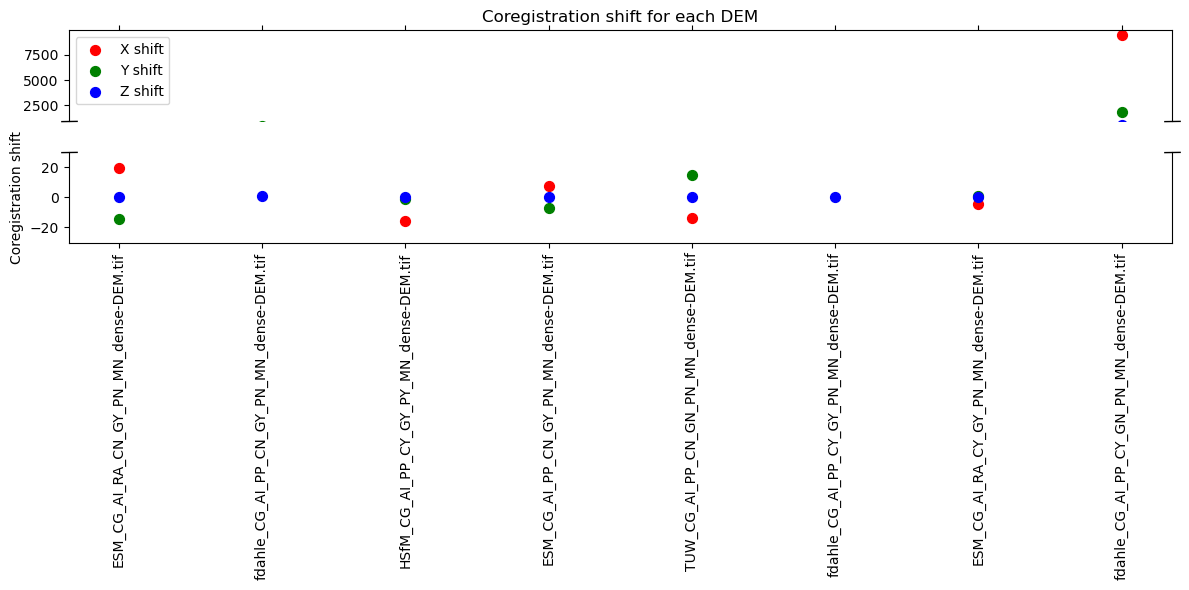

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import os

df = pd.read_csv(os.path.join(DDEM_PLOTS_DIRECTORY, "statistics.csv"), index_col=0)
x = range(len(df))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))
fig.subplots_adjust(hspace=0.05)

# Tracer chaque shift avec couleurs
colors = ["red", "green", "blue"]
labels = ["X shift", "Y shift", "Z shift"]
for col, color, label in zip(["coreg_shift_x","coreg_shift_y","coreg_shift_z"], colors, labels):
    ax1.scatter(x, df[col], color=color, s=50, label=label)
    ax2.scatter(x, df[col], color=color, s=50, label=label)

# Limites Y
ax1.set_ylim(1000, df[["coreg_shift_x","coreg_shift_y","coreg_shift_z"]].max().max()*1.05)  # outliers
ax2.set_ylim(-30, 30)  # majorité des valeurs

# Couper les spines
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

# Slanted lines pour indiquer la coupure
d = .015
kwargs = dict(marker=[(-1,-d),(1,d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Labels DEM
ax2.set_xticks(x)
ax2.set_xticklabels(df.index, rotation=90)

ax2.set_ylabel("Coregistration shift")
ax1.legend(loc="upper left")
ax1.set_title("Coregistration shift for each DEM")
plt.tight_layout()
plt.show()


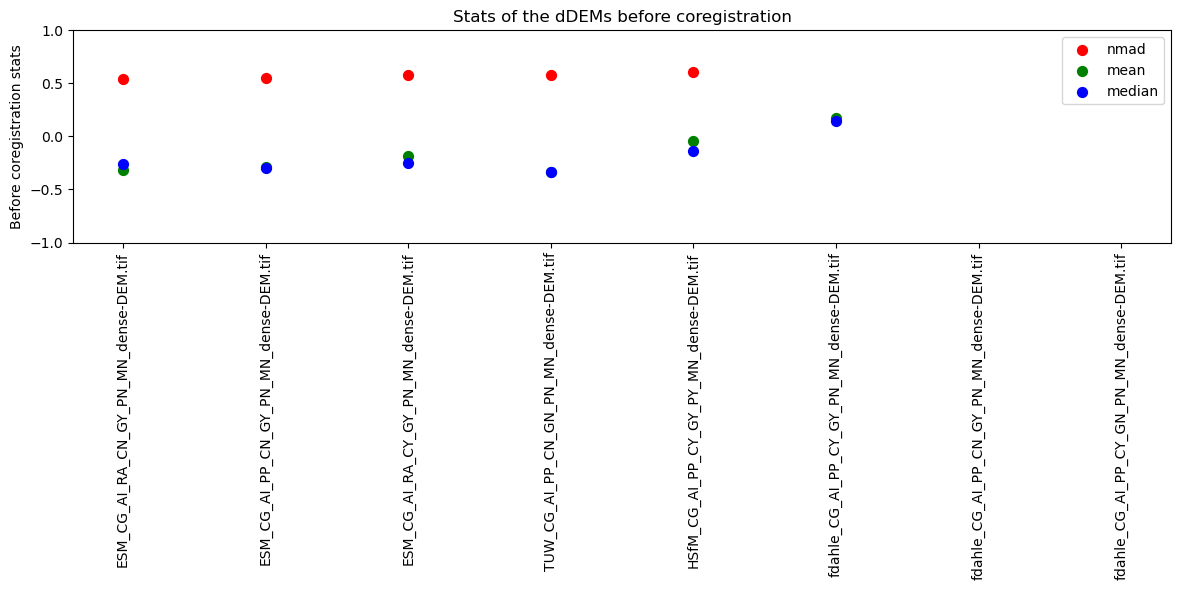

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Charger CSV
df = pd.read_csv(os.path.join(DDEM_PLOTS_DIRECTORY, "statistics.csv"), index_col=0)

# Trier par nmad
df = df.sort_values("before_coreg_nmad")

# Positions X
x = range(len(df))

# Plot
fig, ax = plt.subplots(figsize=(12,6))

colors = ["red", "green", "blue"]
labels = ["nmad", "mean", "median"]

for col, color, label in zip(["before_coreg_nmad","before_coreg_mean","before_coreg_median"], colors, labels):
    ax.scatter(x, df[col], color=color, s=50, label=label)

ax.set_title("Stats of the dDEMs before coregistration")
ax.set_ylim(-1, 1)
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=90)

ax.set_ylabel("Before coregistration stats")
ax.legend()
plt.tight_layout()
plt.show()


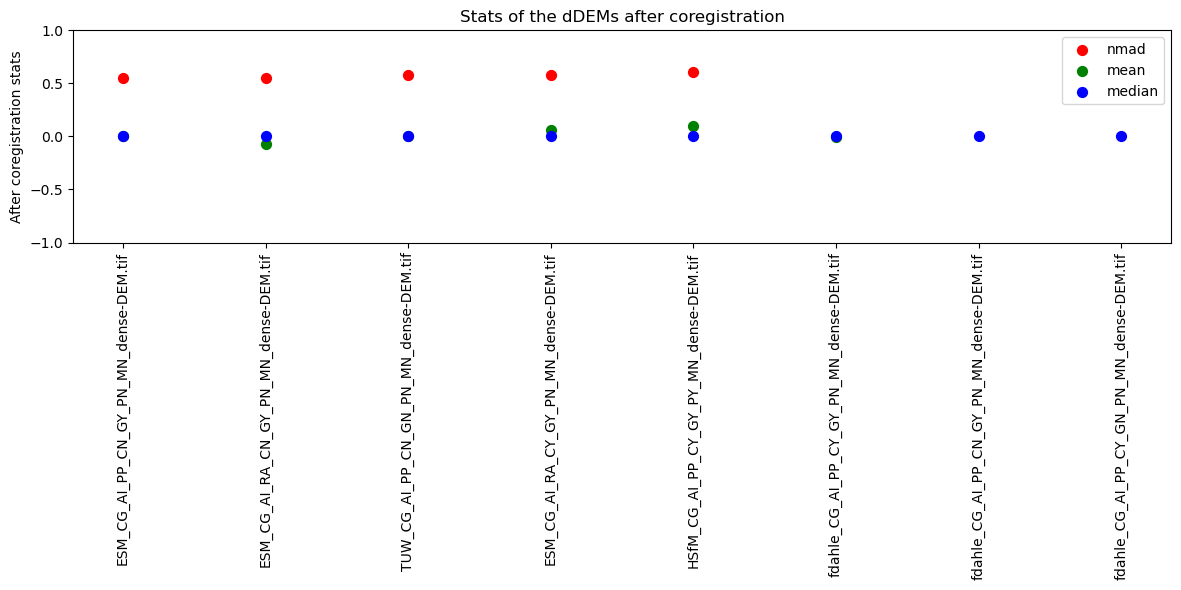

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Charger CSV
df = pd.read_csv(os.path.join(DDEM_PLOTS_DIRECTORY, "statistics.csv"), index_col=0)

# Trier par nmad
df = df.sort_values("after_coreg_nmad")

# Positions X
x = range(len(df))

# Plot
fig, ax = plt.subplots(figsize=(12,6))

colors = ["red", "green", "blue"]
labels = ["nmad", "mean", "median"]

for col, color, label in zip(["after_coreg_nmad","after_coreg_mean","after_coreg_median"], colors, labels):
    ax.scatter(x, df[col], color=color, s=50, label=label)

ax.set_title("Stats of the dDEMs after coregistration")
ax.set_ylim(-1, 1)
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=90)

ax.set_ylabel("After coregistration stats")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
history.postprocessing.create_std_ddem(DDEMS_DIRECTORY, os.path.join(DDEMS_DIRECTORY, "ddem_std.tif"))

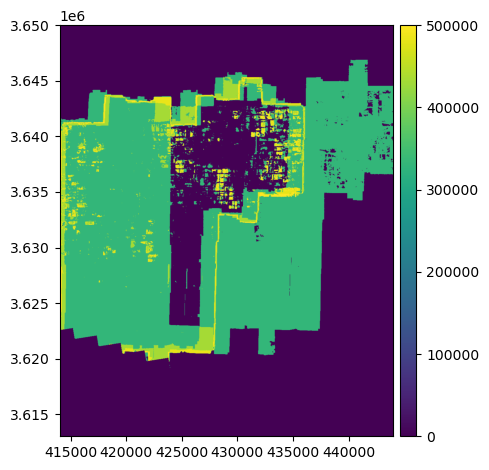

In [31]:
import geoutils as gu

dem_ref = gu.Raster(os.path.join(DDEMS_DIRECTORY, "ddem_std.tif"))
dem_ref.plot()

In [59]:
import geoutils as gu
import numpy as np
import pandas as pd

dem_file = "/home/godinlu/github/history/dev/testset/coregistered_dems/HSfM_CG_AI_PP_CY_GY_PY_MN_dense-DEM.tif"
landcover_file = "/home/godinlu/github/history/dev/testset/ref_dems/casa_grande_landcover_zoom_30m.tif"

# Charger les rasters
dem = gu.Raster(dem_file)
landcover = gu.Raster(landcover_file)

assert dem.shape == landcover.shape
assert dem.transform == landcover.transform

# Masque des nodata dans le DEM
dem_is_nodata = dem.data.mask

# Tableau numpy du landcover
lc_array = landcover.data.astype(int)

# Classes uniques du landcover
classes = np.unique(lc_array[~np.isnan(lc_array)])

# Calcul des proportions
records = []
for cls in classes:
    cls_mask = lc_array == cls

    total = np.count_nonzero(cls_mask)
    nodata = np.count_nonzero(cls_mask & dem_is_nodata)

    proportion = nodata / total if total > 0 else np.nan

    records.append({
        "landcover_class": cls,
        "total_pixels": total,
        "nodata_pixels": nodata,
        "proportion_nodata": proportion
    })

# Convertir en DataFrame pour analyse
df = pd.DataFrame(records)

print(df)


    landcover_class  total_pixels  nodata_pixels  proportion_nodata
0                10          3994           2133           0.534051
1                11           266            148           0.556391
2                12           273            153           0.560440
3                13           243            130           0.534979
4                14           209            100           0.478469
..              ...           ...            ...                ...
66               76            17              8           0.470588
67               77             9              5           0.555556
68               78            17             13           0.764706
69               79            18              6           0.333333
70               80           933            575           0.616292

[71 rows x 4 columns]


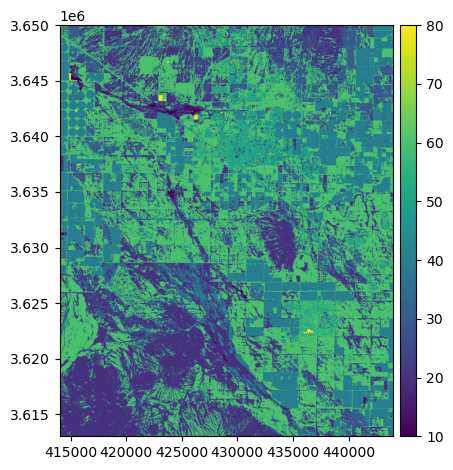

In [57]:
landcover = gu.Raster(landcover_output_file)
landcover.plot()